# Importing required libraries  

In [34]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Loading and reading dataset 

In [2]:
df = pd.read_excel("transaction_fraud_dataset.xlsx")

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# Data information 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104673 entries, 0 to 104672
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            104673 non-null  int64  
 1   type            104673 non-null  object 
 2   amount          104673 non-null  float64
 3   nameOrig        104673 non-null  object 
 4   oldbalanceOrg   104673 non-null  float64
 5   newbalanceOrig  104673 non-null  float64
 6   nameDest        104673 non-null  object 
 7   oldbalanceDest  104673 non-null  float64
 8   newbalanceDest  104673 non-null  float64
 9   isFraud         104673 non-null  int64  
 10  isFlaggedFraud  104673 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 8.8+ MB


# Data Cleaning 

In [5]:
# Checking null values
print(f"The null value present in the dataset is: {df.isnull().sum().sum()}")

The null value present in the dataset is: 0


In [6]:
# Checking for duplicate rows
duplicates = df.duplicated()

# Display the count of duplicate rows
print("Number of duplicate rows:", duplicates.sum())

Number of duplicate rows: 0


# Exploratory Data Analysis 

In [7]:
# Data description
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,104673.000000,1.046730e+05,1.046730e+05,1.046730e+05,1.046730e+05,1.046730e+05,104673.000000,104673.0
mean,8.566622,1.750786e+05,8.991481e+05,9.152130e+05,8.825144e+05,1.184994e+06,0.001146,0.0
std,1.811034,3.467040e+05,2.802071e+06,2.839668e+06,2.396014e+06,2.790382e+06,0.033840,0.0
min,1.000000,3.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,8.000000,1.009296e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,9.000000,5.418827e+04,2.021800e+04,0.000000e+00,2.147500e+04,5.520616e+04,0.000000,0.0
75%,10.000000,2.133042e+05,1.964289e+05,2.211206e+05,5.977141e+05,1.074978e+06,0.000000,0.0
max,10.000000,1.000000e+07,3.893942e+07,3.894623e+07,3.400874e+07,3.894623e+07,1.000000,0.0


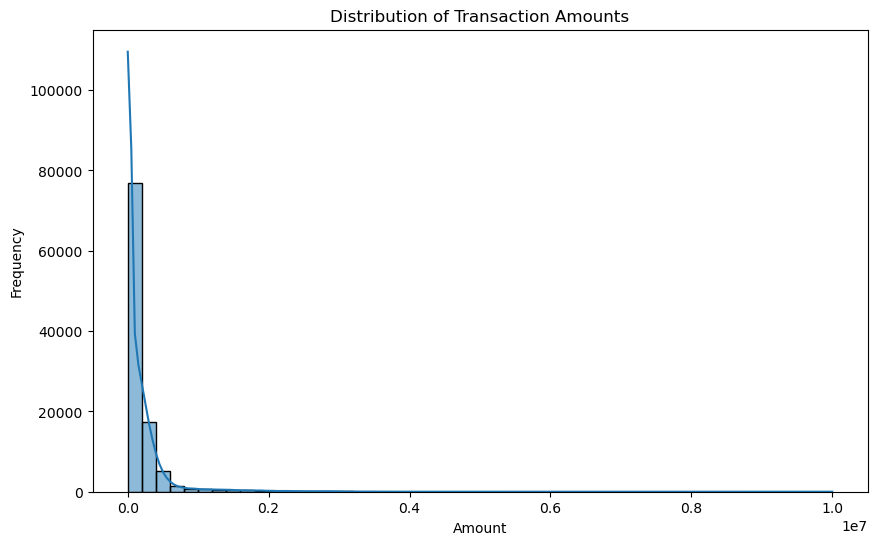

In [8]:
# Histogram for Transaction Amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


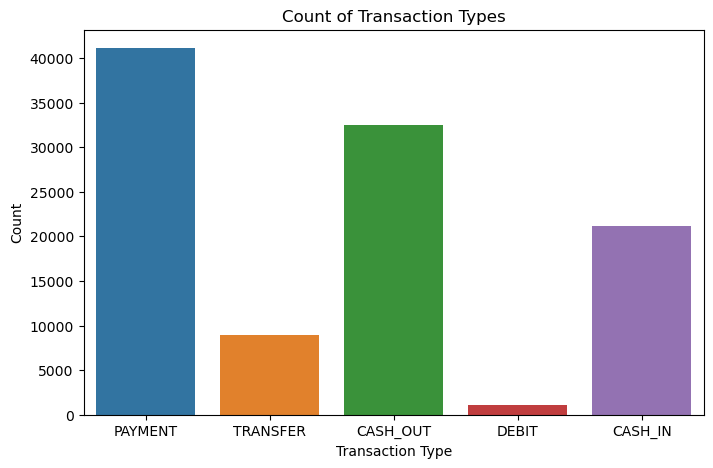

In [9]:
# Count Plot for Transaction Types
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='type')
plt.title('Count of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()


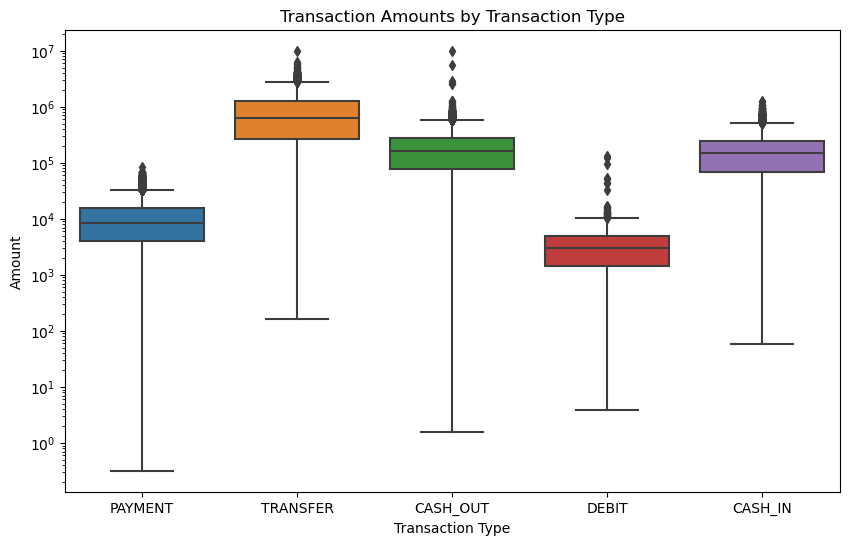

In [10]:
# Box Plot for Amounts by Transaction Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='amount', data=df)
plt.title('Transaction Amounts by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Amount')
plt.yscale('log')  
plt.show()


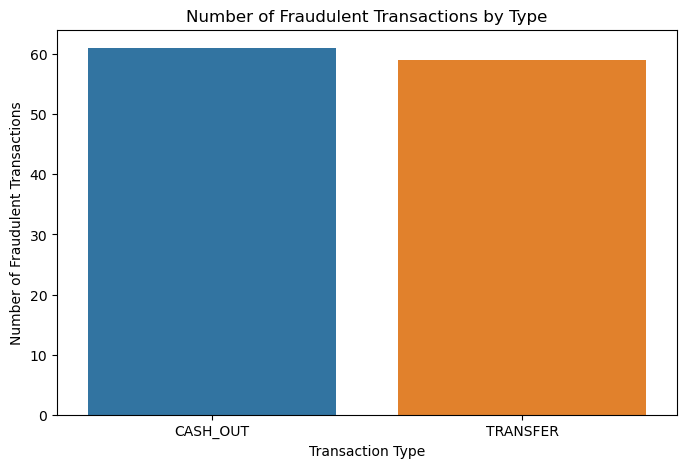

In [11]:
# Bar Plot for Fraudulent Transactions by Type
plt.figure(figsize=(8, 5))
fraud_counts = df[df['isFraud'] == 1]['type'].value_counts()
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title('Number of Fraudulent Transactions by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()


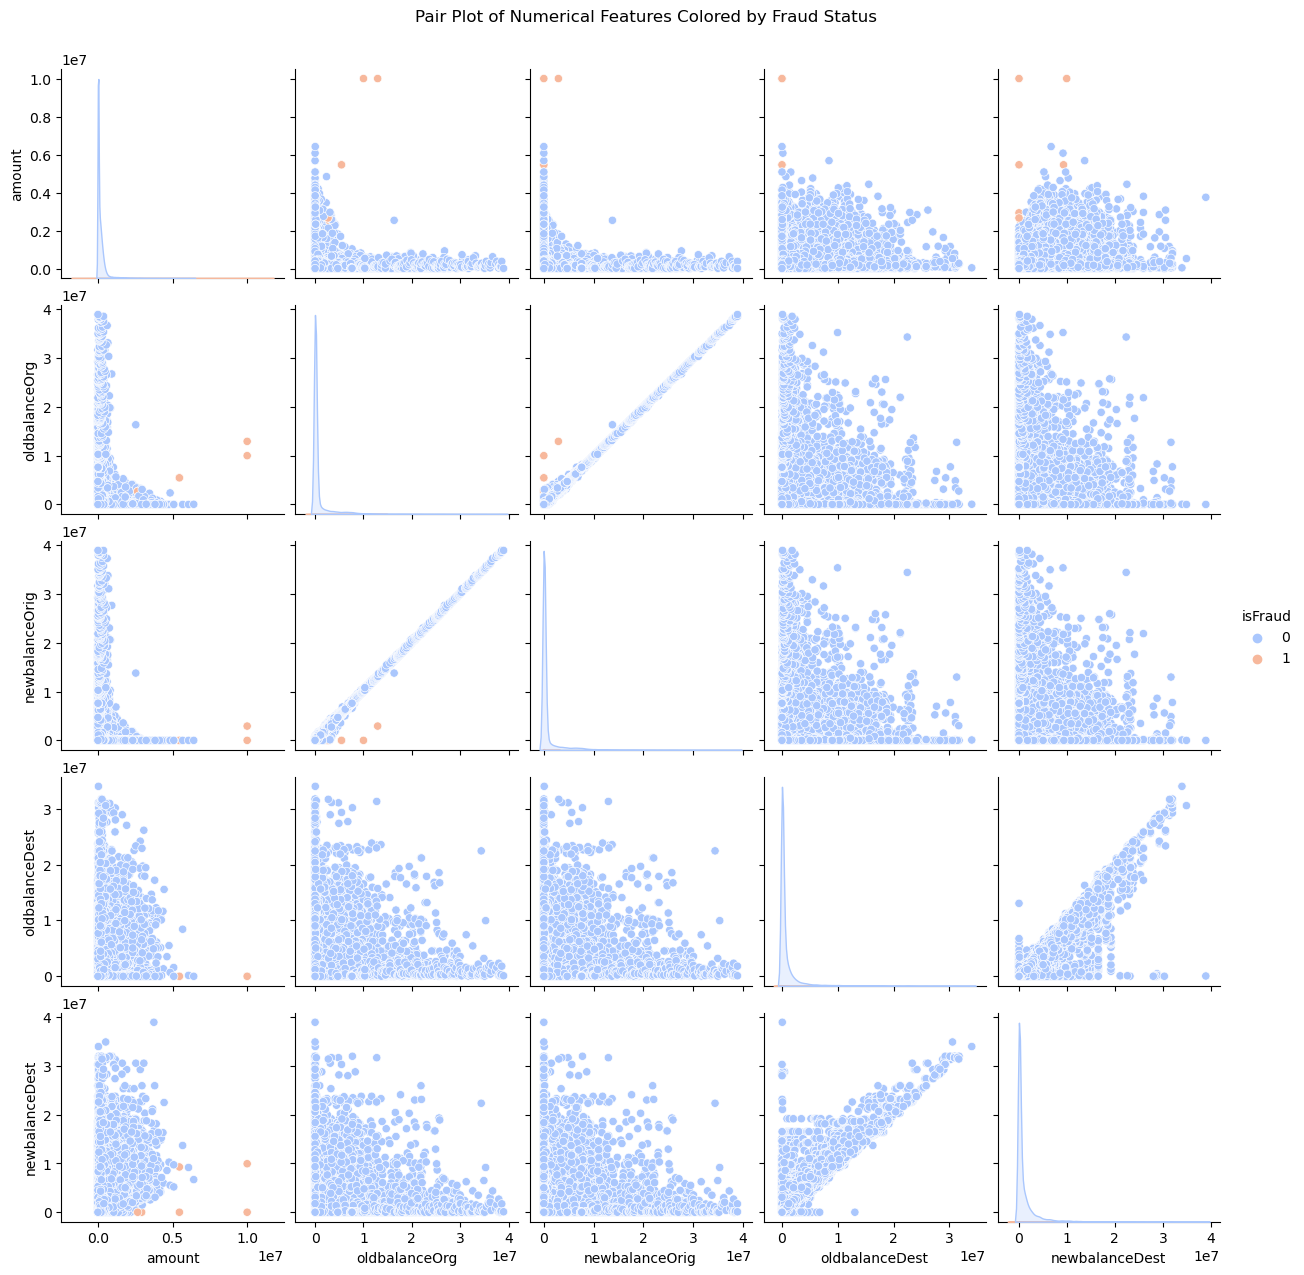

In [12]:
# Pair Plot for Relationships Between Features
sns.pairplot(df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']], hue='isFraud', palette='coolwarm')
plt.suptitle('Pair Plot of Numerical Features Colored by Fraud Status', y=1.02)
plt.show()


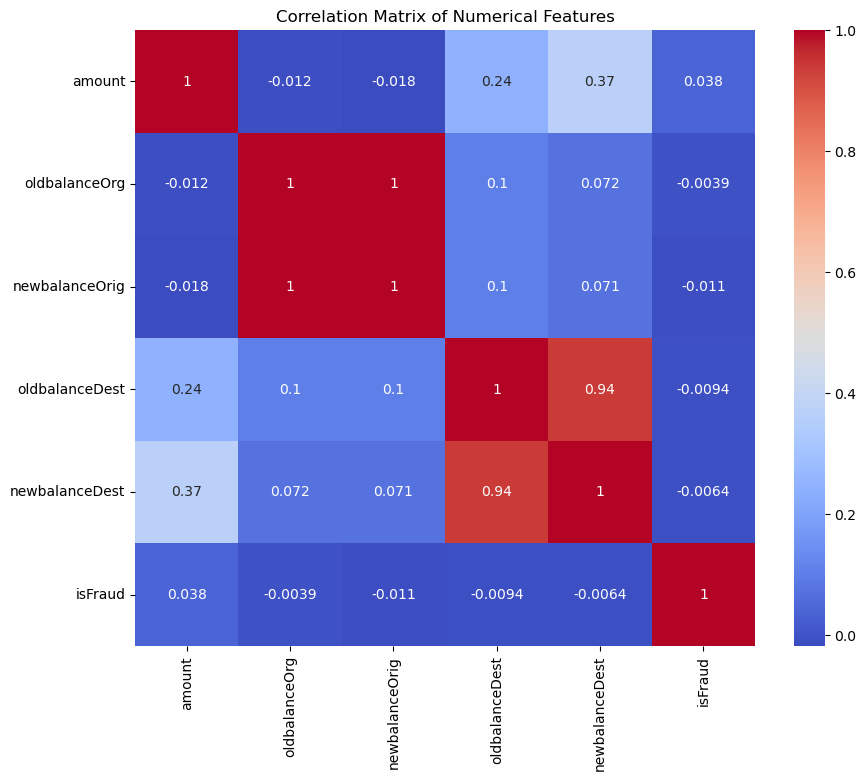

In [13]:
# Correlation Heatmap for Numerical Features
plt.figure(figsize=(10, 8))
correlation_matrix = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


# Data Preprocessing 

In [14]:
# Encoding categorical variable 'type'
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])

In [15]:
# Scaling numerical features
scaler = StandardScaler()
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [16]:
# Splitting the dataset into features and target variable
X = df.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)
y = df['isFraud']

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Random Forest model

In [18]:
# Random Forest Classifier initilization and model training 
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [23]:
# Model evaluation 
rf_predictions = rf_model.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_predictions))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20911
           1       1.00      0.46      0.63        24

    accuracy                           1.00     20935
   macro avg       1.00      0.73      0.81     20935
weighted avg       1.00      1.00      1.00     20935

Random Forest Accuracy: 0.99937903033198


# Gradient Boosting classifier model 

In [20]:
# Gradient Boosting Classifier model initialization and model training
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(random_state=42)

In [21]:
# Model Evaluation for Gradient Boosting Classifier
y_pred_gb = gb.predict(X_test)
y_pred_proba_gb = gb.predict_proba(X_test)[:, 1]

print("Gradient Boosting Classifier:")
print(classification_report(y_test, y_pred_gb))
print("Accuracy:", accuracy_score(y_test, y_pred_gb))

Gradient Boosting Classifier:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     20911
           1       0.04      1.00      0.08        24

    accuracy                           0.97     20935
   macro avg       0.52      0.99      0.53     20935
weighted avg       1.00      0.97      0.99     20935

Accuracy: 0.9729639359923573


# Model Comparison using different graphs

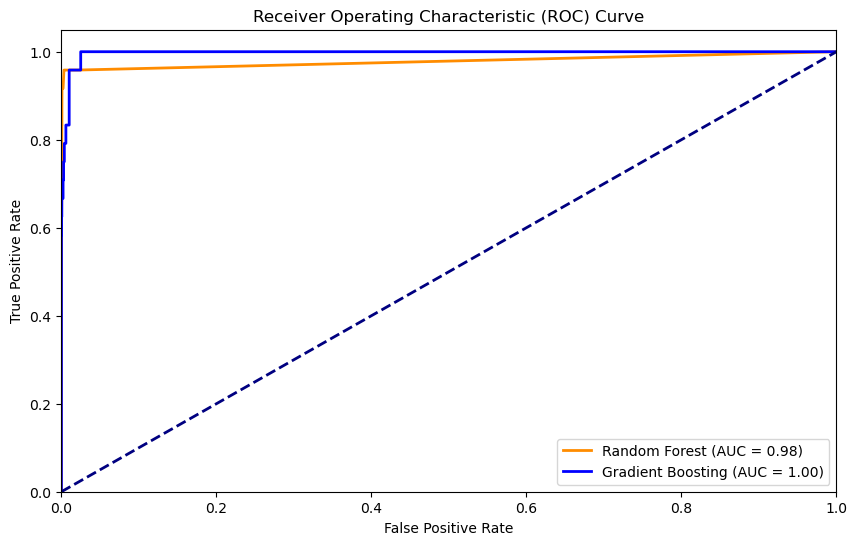

In [25]:
# ROC AUC for Random Forest
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

# ROC AUC for Gradient Boosting
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)

# Plotting ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_gb, tpr_gb, color='blue', lw=2, label='Gradient Boosting (AUC = %0.2f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

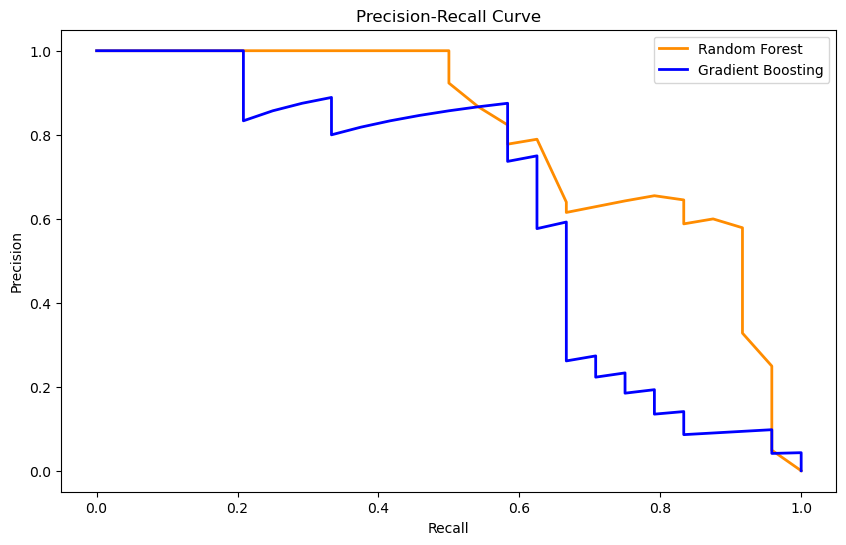

In [26]:
# Precision-Recall for Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
# Precision-Recall for Gradient Boosting
precision_gb, recall_gb, _ = precision_recall_curve(y_test, y_pred_proba_gb)

plt.figure(figsize=(10, 6))
plt.plot(recall_rf, precision_rf, color='darkorange', lw=2, label='Random Forest')
plt.plot(recall_gb, precision_gb, color='blue', lw=2, label='Gradient Boosting')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


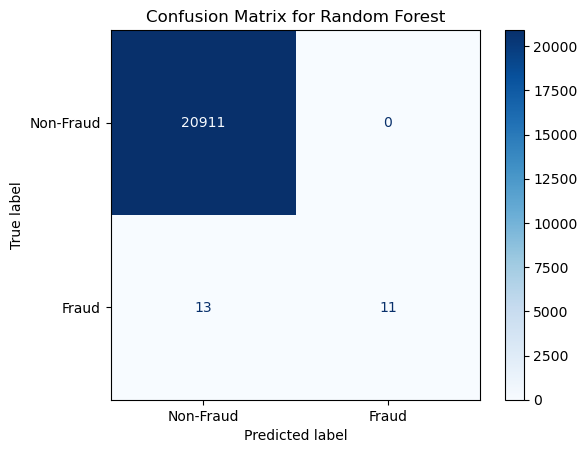

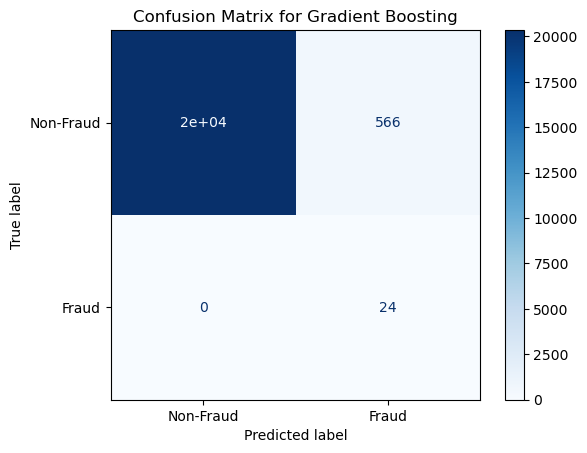

In [27]:
# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, rf_predictions)
ConfusionMatrixDisplay(conf_matrix_rf, display_labels=['Non-Fraud', 'Fraud']).plot(cmap='Blues')
plt.title('Confusion Matrix for Random Forest')
plt.show()

# Confusion Matrix for Gradient Boosting
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
ConfusionMatrixDisplay(conf_matrix_gb, display_labels=['Non-Fraud', 'Fraud']).plot(cmap='Blues')
plt.title('Confusion Matrix for Gradient Boosting')
plt.show()


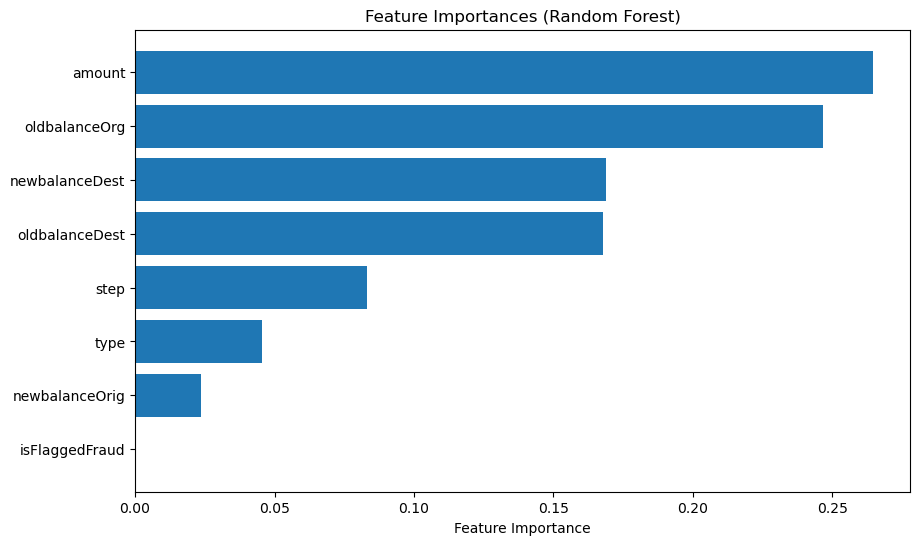

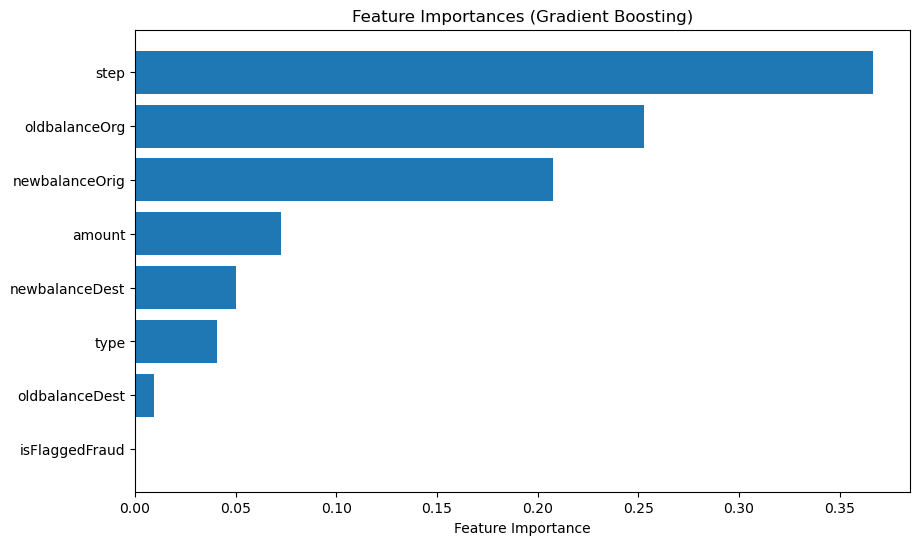

In [30]:
# Feature Importance for Random Forest
features = X.columns
importances_rf = rf_model.feature_importances_
indices_rf = np.argsort(importances_rf)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances (Random Forest)')
plt.barh(range(X.shape[1]), importances_rf[indices_rf], align='center')
plt.yticks(range(X.shape[1]), features[indices_rf])
plt.xlabel('Feature Importance')
plt.show()

# Feature Importance for Gradient Boosting
importances_gb = gb.feature_importances_
indices_gb = np.argsort(importances_gb)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances (Gradient Boosting)')
plt.barh(range(X.shape[1]), importances_gb[indices_gb], align='center')
plt.yticks(range(X.shape[1]), features[indices_gb])
plt.xlabel('Feature Importance')
plt.show()


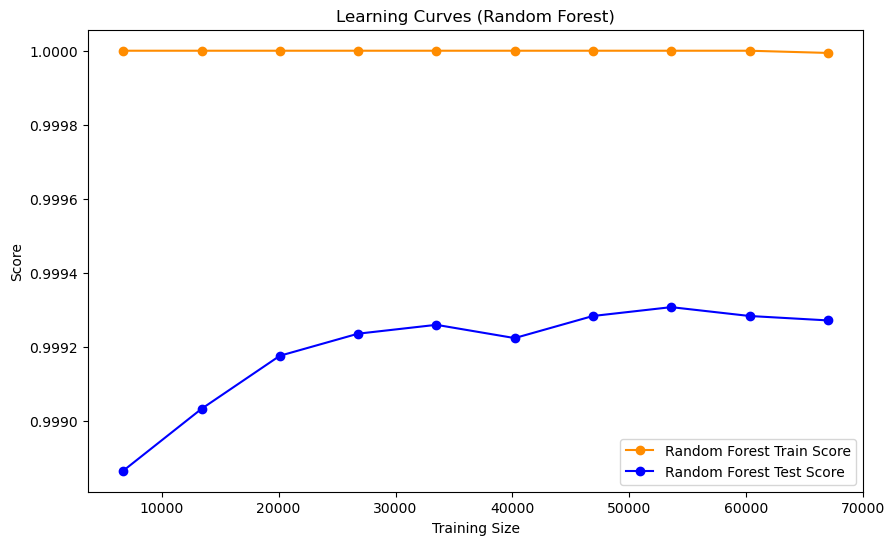

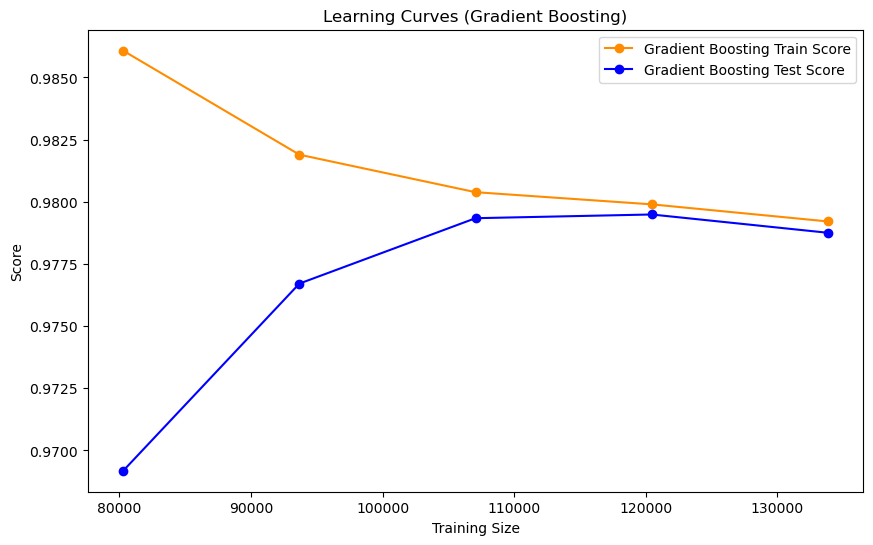

In [31]:
# Learning curves for both the models 
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='darkorange', label='Random Forest Train Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='blue', label='Random Forest Test Score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curves (Random Forest)')
plt.legend(loc='best')
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    gb, X_train_resampled, y_train_resampled, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='darkorange', label='Gradient Boosting Train Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='blue', label='Gradient Boosting Test Score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curves (Gradient Boosting)')
plt.legend(loc='best')
plt.show()
